In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
import sklearn
from skimage.io import imread, imshow
from skimage.filters import gaussian
from skimage.transform import rescale
import os
import random
import skimage
from skimage import io, exposure
from sklearn.linear_model import LinearRegression, RidgeClassifier, LogisticRegression 
from sklearn.svm import SVC
import pickle
import collections
from statistics import mean
from skimage.draw import rectangle, set_color

In [4]:
#GLOBAL PARAMETERS

IMAGE_LOAD_SIZE = 20000 #The amount of board files to load
DROP_BLANKS_PCT = .8 #When learning squares, drop this percent of blank squares from fitting
SAVE_CLASSIFIER = True #Saves squares classifier after fit
HIGH_ERR_THRESHHOLD = 1 #The number of errors a matrix has to have to get flagged as 'high error'


PIECE_LIST = 'prnbqkPRNBQK' #FEN piece codes. Case represents color.
PIECE_NAMES = "Blank,Black Pawn,Black Rook,Black Knight,Black Bishop,Black Queen,Black King,White Pawn,White Rook,White Knight,White Bishop,White Queen,White King".split(',')
PIECE_NAME_DICT = {} #dictionary from piece code to peice name
PIECE_NUM_DICT = {} #dictionary from piece char to piece num


#Fill Dictionaries
PIECE_NAME_DICT[0] = 'Blank'
for ii in range(1, len(PIECE_LIST)+1):
    PIECE_NUM_DICT[PIECE_LIST[ii-1]] = ii
    if ii<13:
        PIECE_NAME_DICT[ii] = PIECE_NAMES[ii]
        


In [5]:
#This function just lets us see progress bars, dont worry about it.

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [7]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

#IMPORTANT
def preprocess(img):
    img = skimage.filters.gaussian(img, sigma = 3)
    img = rescale(img, .2, anti_aliasing = True)
    #img = exposure.equalize_hist(img)
    return img


def load_imgs(size):
    path = './archive/train/' #SET THIS PATH TO YOUR IMAGES
    board_mats = []
    board_imgs = []
    count = 0
    
    for item in log_progress(os.listdir(path), every = 100):
        image = imread(path + item,  as_gray = True)
        image = preprocess(image)
        board_imgs.append(image)
        board_mats.append(convert_fen_to_arr(item[:-5]))
        count = count + 1
        if (count > size-1) and not size == -1:
            return board_imgs, board_mats
            
    return board_imgs, board_mats
    
    
def convert_fen_to_arr(fen):
    fen = fen.split('-')
    board = np.zeros(64)
    file = 0
    for rank_idx, rank_str in enumerate(fen):
        for char in rank_str:
            if is_number(char):
                for cols in range(int(char)):
                    board[file + cols] = 0
                file = file + int(char)
            else:
                board[file] = PIECE_NUM_DICT[char]
                file = file + 1
                
    return board

#blank_pct should be a number between 0 and 1 representing the percent of blank squares we want to retain
def split_board(board_imgs, board_mats, blank_pct = 1):
    targets = []
    features = []
    dropped = 0
    
    if(blank_pct > 1 or blank_pct < 0):
        raise ValueError("Percent Blank Boards Must Be < 1 and > 0, defaulting to 100%")
        blank_pct = 1
    
    
    
    for index, board_arr in enumerate(board_imgs):

        board_img = np.reshape(board_arr, (80,80))
        tiles = skimage.util.shape.view_as_blocks(board_img, block_shape=(10, 10))
        board_mat = np.reshape(board_mats[index], (8,8))
        
        
        for row in range(8):
            for col in range(8):
                
                feature = tiles[row][col]
                target = board_mat[row][col]
                
                #If the target is blank, there is a chance to drop the sample
                add = True
                if target == 0.0:
                    if(random.random() > blank_pct):
                        add = False
                        dropped = dropped + 1
                if(add):    
                    targets.append(target)
                    features.append(np.ndarray.flatten(feature))
               
    return features, targets, dropped


In [8]:
imgs, mats = load_imgs(IMAGE_LOAD_SIZE)   

5683
[[ 4.  0.  0.  0.  0.  0.  0.  3.]
 [ 0. 12.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  5.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  0.  3.  0.]
 [ 0.  0.  0.  0.  0.  0.  4.  7.]
 [ 0.  6.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]
[ 4.  0.  0.  0.  0.  0.  0.  3.  0. 12.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  2.  0.  3.  0.  0.  0.  0.  0.  0.  0.  4.  7.  0.  6.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


/opt/anaconda3/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


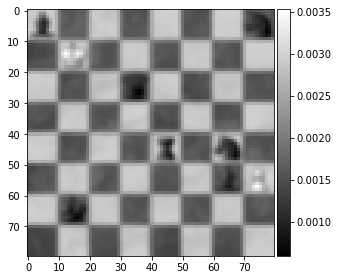

In [6]:
#Test random board image vs board matrix
rand = random.randint(0,len(imgs))
print(rand)
imshow(imgs[rand]/255.0, cmap='gray')
print(np.reshape(mats[rand], (8,8)))
print(mats[rand])


In [7]:
#Split the whole image set. We will do regression on the squares of our train set (by splitting it again), 
#then see if we can anylize our boards

imgs_train, imgs_test, mats_train, mats_test = sklearn.model_selection.train_test_split(imgs, mats, test_size = .2)

Splitting Train Squares.
Splitting Test Squares.
Initializing Multinomial Classifier.
Beginning fit with 680895 squares and 138305 dropped blanks.


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   5 | elapsed: 254.1min remaining: 381.1min
[Parallel(n_jobs=-2)]: Done   3 out of   5 | elapsed: 254.8min remaining: 169.9min
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed: 261.4min remaining:    0.0s
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed: 261.4min finished
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


Accuracy: 0.9994921875	
[[172414      0      0      0      0      0      0      0      0      0
       0      0      0]
 [     3   2888      3      2      0      0      0      0      0      0
       0      0      0]
 [     6      0   2843      1      2      2      0      0      0      0
       0      0      0]
 [     7      2      4   2812      0      6      1      0      0      0
       0      0      0]
 [     3      0      3      2   2902      3      4      0      0      0
       0      0      0]
 [     3      1      1      2      1   1460      8      0      0      0
       0      0      0]
 [     7      0      2      1      4      5   3181      0      0      0
       0      0      0]
 [     1      3      0      0      0      0      0   2863      0      0
       0      0      0]
 [     0      0      0      0      0      0      0      1   2908      0
       0      1      0]
 [     2      0      0      0      0      0      0      0      2   2893
       0      1      0]
 [     0      0 

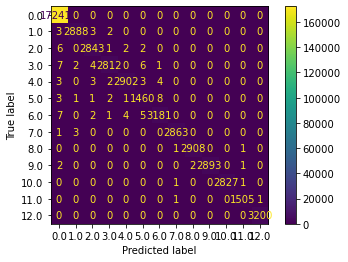

In [8]:
#Squares regression
squares_img_train, squares_img_test, y_piece_train, y_piece_test = sklearn.model_selection.train_test_split(imgs_train, mats_train, test_size = .2)

print("Splitting Train Squares.")
squares, pieces, dropped = split_board(squares_img_train, y_piece_train, DROP_BLANKS_PCT)

print("Splitting Test Squares.")
test_squares, test_pieces, _ = split_board(squares_img_test, y_piece_test)

print("Initializing Multinomial Classifier.")
clf = sklearn.linear_model.LogisticRegressionCV(multi_class='multinomial', 
                                              solver='newton-cg', 
                                              fit_intercept = True, 
                                              verbose = 10, 
                                              n_jobs = -2 ) #n_jobs is allocating your cpu cores, where -2 is one less than your max
#clf = sklearn.linear_model.RidgeClassifierCV(fit_intercept = True)
print('Beginning fit with ' + str(len(squares)) + ' squares and ' + str(dropped) + ' dropped blanks.')
clf.fit(squares, pieces)


predictions = clf.predict(test_squares)
accuracy = sklearn.metrics.accuracy_score(test_pieces, predictions)
print('Accuracy: ' + str(accuracy)+'\t')
print(sklearn.metrics.confusion_matrix(test_pieces, predictions))
sklearn.metrics.plot_confusion_matrix(clf, test_squares, test_pieces)


In [2]:
with open('clf_acc09994_tm20201118.pkl', 'rb') as f:
    clf = pickle.load(f)

predictions = clf.predict(test_squares)
accuracy = sklearn.metrics.accuracy_score(test_pieces, predictions)
print('Accuracy: ' + str(accuracy)+'\t')
print(sklearn.metrics.confusion_matrix(test_pieces, predictions))
sklearn.metrics.plot_confusion_matrix(clf, test_squares, test_pieces)

NameError: name 'pickle' is not defined

In [9]:
#If save_classifier is set to true, pickles the classifer to your local directory
import datetime
if(SAVE_CLASSIFIER):
    file_name = "clf_" + 'acc' + str(accuracy).split('.')[0] + '' + str(accuracy).split('.')[1][:4] + '_tm' + str(datetime.datetime.now().strftime('%Y%m%d')) + '.pkl'
    with open(file_name, 'wb') as fid:
        pickle.dump(clf, fid)   

In [10]:
#Board Prediction imgs_test mats_test

board_predictions = []
board_real = []
for index, board in log_progress(enumerate(imgs_test), every = 10):
    squares, pieces, _ = split_board([board], [mats_test[index]])
    board_predictions.append(clf.predict(squares))
    board_real.append(pieces)
    
total = 0
perfect = 0
err_counts = {}
high_err_mats = {}
confusion_matrix = np.zeros((13,13))


for index, board in log_progress(enumerate(board_predictions), every = 10):
    
    err_count = 0
    err_idxs = []
    if(np.array_equal(board, board_real[index])):
        perfect = perfect + 1
    else:  
        for ii in range(len(board)):
            predicted = int(board[ii])
            actual = int(board_real[index][ii])
            if(not predicted == actual):
                confusion_matrix[actual][predicted] = confusion_matrix[actual][predicted] + 1
                err_count = err_count + 1
                err_idxs.append([ii, predicted, actual])
        
    err_counts[index] = err_count
    if(err_count>=HIGH_ERR_THRESHHOLD):
        high_err_mats[index] = err_idxs
    total = total + 1
    
print('Perfect Board Count: ' + str(perfect))
print('Total Board Count: ' + str(total)) 
print('Percent Perfect: ' + str(np.round(perfect/total, 2)*100)[0:] + "%")    
print('Average Errored Squares Per Board: ' + str(np.round(mean(err_counts.values()), 2)))
print('\nConfusion Matrix (Diagonal Zeroed):\n')      
print(confusion_matrix)

Perfect Board Count: 3896
Total Board Count: 4000
Percent Perfect: 97.0%
Average Errored Squares Per Board: 0.03

Confusion Matrix (Diagonal Zeroed):

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 3.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 4.  1.  0.  1.  2.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 5.  5.  2.  0.  0.  6.  1.  0.  0.  0.  0.  0.  0.]
 [ 3.  2.  3.  1.  0.  5.  3.  0.  0.  0.  1.  0.  0.]
 [ 9.  0.  1.  3.  2.  0. 11.  0.  0.  0.  0.  0.  0.]
 [ 7.  0.  0.  3.  5.  4.  0.  0.  0.  1.  0.  0.  0.]
 [ 3.  2.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  2.  0.  0.  0.  0.]
 [ 0.  0.  2.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 3.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]]


  Coordinates   Predicted        Actual
0      (0, 7)  White Rook  White Knight


<Figure size 432x288 with 0 Axes>

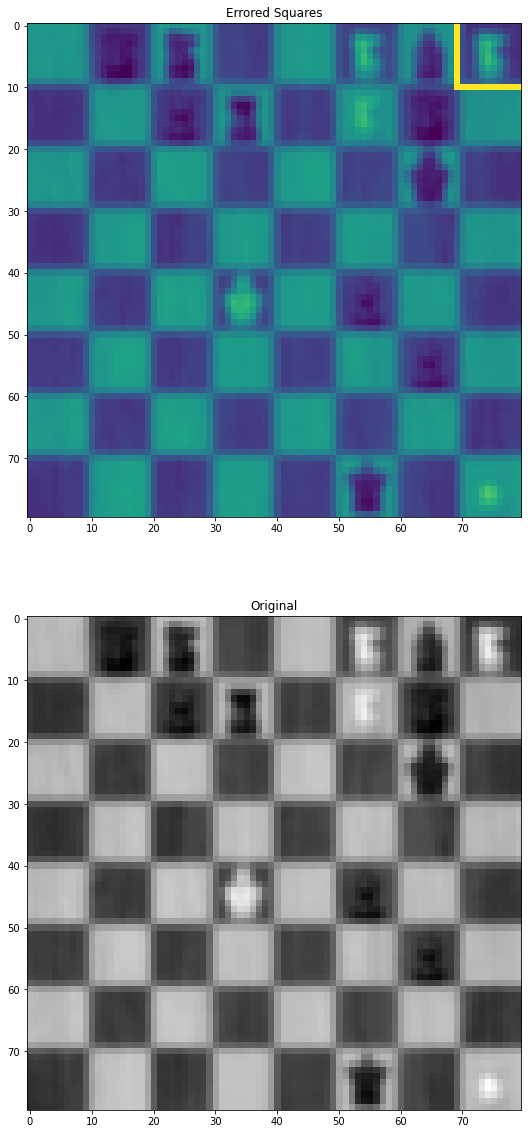

In [11]:
coords = np.zeros(64)
count = 0
for i in range(64):
    coords[i] = count
    count = count + 1
coords = np.reshape(coords, (8,8))
index, error = random.choice(list(high_err_mats.items()))
err_img = np.copy(imgs_test[index])
readout = pd.DataFrame(columns=['Coordinates', 'Predicted', 'Actual'] )
for ii in high_err_mats[index]:
    rank,file = np.where(coords == ii[0])
    start = (rank[0]*10, file[0]*10 )
    extent = (10, 10)
    rr,cc= skimage.draw.rectangle_perimeter(start=start, extent=extent, shape=(80,80))
    set_color(err_img, (rr,cc), 1)
    readout = readout.append({'Coordinates': (rank[0], file[0]),
                         'Predicted': PIECE_NAME_DICT[ii[1]],
                         'Actual': PIECE_NAME_DICT[ii[2]]}, ignore_index=True)

print(readout)
plt.figure()
f, axarr = plt.subplots(2,1, figsize=(20,20)) 
axarr[0].set_title('Errored Squares')
axarr[0].imshow(err_img)
axarr[1].set_title('Original')
axarr[1].imshow(imgs_test[index]/255., cmap='gray')